# RSRN

## import and init 

In [1]:
import torch 

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


SEED = 42

def set_seeds(seed=42):
    """Set seeds for reproducability."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seeds(seed=SEED)

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
cuda = True
device = torch.device('cuda' if (
    torch.cuda.is_available() and cuda) else 'cpu')
torch.set_default_tensor_type('torch.FloatTensor')
if device.type == 'cuda':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
print (device)

cuda


-input :
    size of input is (seq_len, batch, input_size)
    If batch_first=True (batch, seq_len, input_size)
-output :
    -out: output of the RNN
        size (seq_len, batch, num_directions * hidden_size)
        If batch_first=True (batch, seq_len, num_directions * hidden_size)
        
    -h_n : hidden value from the last time-step of all RNN layers
        (num_layers * num_directions, batch, hidden_size). h_n
        unaffected by batch_first=True

## define RNN : Elman RNN or LSTM or GRU

In [141]:

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,RNN_type="rnn"):
        super(RNNModel, self).__init__()
        self.RNN_type=RNN_type
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        if self.RNN_type=="rnn":
            self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        elif self.RNN_type=="lstm":
            self.rnn=nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        elif self.RNN_type=="gru":
            self.rnn = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True)
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def init_hidden(self,x,rng=False): 
        # (batch_size, RNN_hidden_size)
        if random:
            hidden=torch.randint(2,(self.layer_dim,x.size(0), self.hidden_dim)).float()
        else:
            hidden=torch.zeros(self.layer_dim, x.size(0), self.hidden_dim) # +0.5 in the paper but first test with 0 
        return hidden
    
    def forward(self,x,**kwargs):
        
        # Initialize hidden state with zeros
        h = kwargs.get('h', None)
        c = kwargs.get('c', None)
            
        # One time step
        if self.RNN_type=="rnn" or self.RNN_type=="gru":
            out, h = self.rnn(x, h) # of shape (seq_len, batch, num_directions(=1 undirectionel) * hidden_size)
        elif self.RNN_type=="lstm":
            out, (h, c) = self.rnn(x,(h,c))

        # out=>torch.Size([1, 10, 50]) size_batch=1, size_seq=10, hidden_l=50
        out = self.fc(out.view(-1, self.hidden_dim))  #(1*10,50)
        return out,h,c

input_size – The number of expected features in the input x

hidden_size – The number of features in the hidden state h

num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two RNNs together to form a stacked RNN, with the second RNN taking in outputs of the first RNN and computing the final results. Default: 1

## metric function

In [122]:
def get_accuracy(logit, target, batch_size=1,treshold=0.1,teacher_forcing=True):
    ''' Obtain accuracy for training round '''
    corrects = (abs(logit-target)<treshold).sum().item()
    accuracy = 100.0 * corrects/(output_dim*batch_size*(seq_len-1))
    return accuracy,corrects


#test accuracy on one list

def N_correct_liste(model,sequence_to_test):
    inputs=sequence_to_test[:,:-1,:]
    labels=sequence_to_test[:,1:,:]
    with torch.no_grad():
        hidden=model.init_hidden(inputs)
        c=model.init_hidden(inputs)
        loss=0
        accuracy=0
        corrects=0
        size_inputs=inputs[:,0,:].size()
        input_rnn=inputs[:,0,:].view(size_inputs[0],1,size_inputs[1])
        
        for t in range(seq_len-1):
            if model.RNN_type=="lstm":
                outputs,hidden,c = model(input_rnn,h=hidden,c=c)
            else:
                outputs,hidden,_ = model(input_rnn,h=hidden) 
            out=outputs.detach()
            input_rnn=torch.sigmoid(out.view(size_inputs[0],1,size_inputs[1]))
            loss+=criterion(outputs,labels[:,t,:].view(-1, output_dim))
            acc,corr=get_accuracy(torch.sigmoid(outputs), labels[:,t,:].view(-1, output_dim), batch_size=1,treshold=0.1)
            accuracy+=acc 
            corrects+=corr
    return loss.item(),accuracy,corrects



## train function


In [123]:
def train_on_liste(inputs_list,model,model_optimizer, criterion,RNN_type,seq_len,teacher_forcing_ratio=0.5):
    Number_of_corrects_A=[]
    Number_of_corrects_B=[]
    loss_liste=[]
    loss=0
    inputs=inputs_list[:,:-1,:] #remove last element 
    labels=inputs_list[:,1:,:]#remove first element
    for i in range(500):
        loss=0
        accuracy,corrects=0,0
        model_optimizer.zero_grad()
        
        # use Teacher forcing half of the time http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf
        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False  
        if use_teacher_forcing:
            if model.RNN_type=="lstm":
                outputs,_,_ = model(inputs,h=model.init_hidden(inputs),c=model.init_hidden(inputs))
            else:
                outputs,_,_ = model(inputs,h=model.init_hidden(inputs)) 
            
            loss=criterion(outputs,labels.view(-1, output_dim))
            loss.backward()
            accuracy,corrects=get_accuracy(torch.sigmoid(outputs), labels, batch_size=1,treshold=0.1)
        else : # half of the time use output as input
            #init first hidden inputs
            hidden=model.init_hidden(inputs)
            c=model.init_hidden(inputs)
            
            size_inputs=inputs[:,0,:].size()
            input_rnn=inputs[:,0,:].view(size_inputs[0],1,size_inputs[1])

            for t in range(seq_len-1):
                if model.RNN_type=="lstm":
                    outputs,hidden,c = model(input_rnn,h=hidden,c=c)
                else:
                    outputs,hidden,_ = model(input_rnn,h=hidden) 
                out=outputs.detach()
                input_rnn=torch.sigmoid(out.view(size_inputs[0],1,size_inputs[1]))
                loss+=criterion(outputs,labels[:,t,:].view(-1, output_dim))
                acc,corr=get_accuracy(torch.sigmoid(outputs), labels[:,t,:].view(-1, output_dim), batch_size=1,treshold=0.1)
                accuracy+=acc
                corrects+=corr
                loss.backward(retain_graph=True)
        model_optimizer.step()
        los=loss.item() / seq_len
        loss_liste=np.append(loss_liste,los)
        Number_of_corrects_A.append(N_correct_liste(model,A)[1])
        Number_of_corrects_B.append(N_correct_liste(model,B)[1])
        print('Iteration: {}  Loss: {:.3f}  Accuracy: {:.1f} % Correct: {:.1f} / {} Teacher forcing = {}'.format(i, los, accuracy,corrects,output_dim*batch_size*(seq_len-1),use_teacher_forcing))
        if corrects==output_dim*batch_size*(seq_len-1): 
            print("list fully learn with",i,"epochs")
            break
    return Number_of_corrects_A,Number_of_corrects_B


## Define A and B and parameters

In [87]:
RNN_type="rnn"
autoassociative_dim=0
input_dim = 100    # input dimension
hidden_dim = 50  # hidden layer dimension
layer_dim = 1     # number of hidden RNN layers
output_dim = input_dim+autoassociative_dim   # output dimension

batch_size = 1
seq_len=11
 
A=torch.randint(2,(batch_size,seq_len,input_dim)).float() #generate rnadom binary vector of length 100 
A[:,5,:]=A[:,8,:]
B=torch.randint(2,(batch_size,seq_len,input_dim)).float()
B[:,1,:]=B[:,5,:]

#A.is_cuda


# Simulation 1 : catastrophic forgetting in multiple sequence learning

## learn A 

In [97]:
#define model
model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim,RNN_type)
#loss func
criterion = nn.BCEWithLogitsLoss(reduction='sum')# Sigmoid layer and the BCELoss
#opti
optimizer = optim.SGD(model.parameters(), lr=0.001) #lstm gru=0.1 rnn=0.01
Number_of_corrects_A,_=train_on_liste(A,model,optimizer,criterion,RNN_type,seq_len,teacher_forcing_ratio=0.5)


Iteration: 0  Loss: 63.207  Accuracy: 0.0 % Correct: 0.0 / 1000 Teacher forcing = True
Iteration: 1  Loss: 62.504  Accuracy: 0.0 % Correct: 0.0 / 1000 Teacher forcing = True
Iteration: 2  Loss: 61.877  Accuracy: 0.0 % Correct: 0.0 / 1000 Teacher forcing = True
Iteration: 3  Loss: 62.008  Accuracy: 0.0 % Correct: 0.0 / 1000 Teacher forcing = False
Iteration: 4  Loss: 60.280  Accuracy: 0.0 % Correct: 0.0 / 1000 Teacher forcing = False
Iteration: 5  Loss: 58.060  Accuracy: 0.0 % Correct: 0.0 / 1000 Teacher forcing = False
Iteration: 6  Loss: 55.452  Accuracy: 0.9 % Correct: 9.0 / 1000 Teacher forcing = True
Iteration: 7  Loss: 55.279  Accuracy: 0.8 % Correct: 8.0 / 1000 Teacher forcing = False
Iteration: 8  Loss: 53.853  Accuracy: 4.3 % Correct: 43.0 / 1000 Teacher forcing = False
Iteration: 9  Loss: 49.479  Accuracy: 3.9 % Correct: 39.0 / 1000 Teacher forcing = True
Iteration: 10  Loss: 48.957  Accuracy: 3.6 % Correct: 36.0 / 1000 Teacher forcing = False
Iteration: 11  Loss: 49.349  Accu

## Save model with A fully learned 

In [98]:
# Specify a path
PATH = "state_dict_model_with_A_Fully_learn.pt"

# Save
torch.save(model.state_dict(), PATH)


## load model with A fully learned 


In [104]:
model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim,RNN_type)
print(N_correct_liste(model,A)[1])
model.load_state_dict(torch.load(PATH))
print(N_correct_liste(model,A)[1])
criterion = nn.BCEWithLogitsLoss(reduction='sum')# Sigmoid layer and the BCELoss
optimizer = optim.SGD(model.parameters(), lr=0.0001) #test sgd


0.0
100.0


## learn B

In [105]:
Number_of_corrects_A,Number_of_corrects_B=train_on_liste(B,model,optimizer,criterion,"rnn",seq_len,teacher_forcing_ratio=0.5)

Iteration: 0  Loss: 291.968  Accuracy: 46.8 % Correct: 468.0 / 1000 Teacher forcing = True
Iteration: 1  Loss: 156.598  Accuracy: 32.4 % Correct: 324.0 / 1000 Teacher forcing = False
Iteration: 2  Loss: 69.251  Accuracy: 1.6 % Correct: 16.0 / 1000 Teacher forcing = False
Iteration: 3  Loss: 67.356  Accuracy: 1.3 % Correct: 13.0 / 1000 Teacher forcing = True
Iteration: 4  Loss: 66.933  Accuracy: 1.2 % Correct: 12.0 / 1000 Teacher forcing = True
Iteration: 5  Loss: 66.542  Accuracy: 1.1 % Correct: 11.0 / 1000 Teacher forcing = True
Iteration: 6  Loss: 65.070  Accuracy: 1.2 % Correct: 12.0 / 1000 Teacher forcing = False
Iteration: 7  Loss: 64.972  Accuracy: 0.8 % Correct: 8.0 / 1000 Teacher forcing = True
Iteration: 8  Loss: 64.638  Accuracy: 0.5 % Correct: 5.0 / 1000 Teacher forcing = True
Iteration: 9  Loss: 64.329  Accuracy: 0.5 % Correct: 5.0 / 1000 Teacher forcing = True
Iteration: 10  Loss: 63.108  Accuracy: 1.0 % Correct: 10.0 / 1000 Teacher forcing = False
Iteration: 11  Loss: 63.

Iteration: 95  Loss: 48.271  Accuracy: 10.1 % Correct: 101.0 / 1000 Teacher forcing = False
Iteration: 96  Loss: 47.856  Accuracy: 10.8 % Correct: 108.0 / 1000 Teacher forcing = False
Iteration: 97  Loss: 47.867  Accuracy: 11.2 % Correct: 112.0 / 1000 Teacher forcing = True
Iteration: 98  Loss: 47.333  Accuracy: 11.4 % Correct: 114.0 / 1000 Teacher forcing = False
Iteration: 99  Loss: 46.862  Accuracy: 11.7 % Correct: 117.0 / 1000 Teacher forcing = False
Iteration: 100  Loss: 46.926  Accuracy: 12.8 % Correct: 128.0 / 1000 Teacher forcing = True
Iteration: 101  Loss: 46.289  Accuracy: 12.2 % Correct: 122.0 / 1000 Teacher forcing = False
Iteration: 102  Loss: 46.326  Accuracy: 13.3 % Correct: 133.0 / 1000 Teacher forcing = True
Iteration: 103  Loss: 45.714  Accuracy: 12.9 % Correct: 129.0 / 1000 Teacher forcing = False
Iteration: 104  Loss: 45.235  Accuracy: 13.4 % Correct: 134.0 / 1000 Teacher forcing = False
Iteration: 105  Loss: 44.727  Accuracy: 14.5 % Correct: 145.0 / 1000 Teacher f

Iteration: 183  Loss: 23.146  Accuracy: 61.1 % Correct: 611.0 / 1000 Teacher forcing = False
Iteration: 184  Loss: 23.125  Accuracy: 63.3 % Correct: 633.0 / 1000 Teacher forcing = True
Iteration: 185  Loss: 22.855  Accuracy: 61.0 % Correct: 610.0 / 1000 Teacher forcing = True
Iteration: 186  Loss: 22.578  Accuracy: 61.8 % Correct: 618.0 / 1000 Teacher forcing = True
Iteration: 187  Loss: 22.365  Accuracy: 61.4 % Correct: 614.0 / 1000 Teacher forcing = False
Iteration: 188  Loss: 22.280  Accuracy: 63.9 % Correct: 639.0 / 1000 Teacher forcing = True
Iteration: 189  Loss: 21.997  Accuracy: 62.7 % Correct: 627.0 / 1000 Teacher forcing = True
Iteration: 190  Loss: 21.815  Accuracy: 62.3 % Correct: 623.0 / 1000 Teacher forcing = True
Iteration: 191  Loss: 21.625  Accuracy: 62.3 % Correct: 623.0 / 1000 Teacher forcing = False
Iteration: 192  Loss: 21.583  Accuracy: 64.9 % Correct: 649.0 / 1000 Teacher forcing = True
Iteration: 193  Loss: 21.250  Accuracy: 64.3 % Correct: 643.0 / 1000 Teacher 

Iteration: 274  Loss: 6.300  Accuracy: 87.2 % Correct: 872.0 / 1000 Teacher forcing = False
Iteration: 275  Loss: 6.735  Accuracy: 89.2 % Correct: 892.0 / 1000 Teacher forcing = True
Iteration: 276  Loss: 6.197  Accuracy: 88.7 % Correct: 887.0 / 1000 Teacher forcing = False
Iteration: 277  Loss: 7.518  Accuracy: 89.6 % Correct: 896.0 / 1000 Teacher forcing = False
Iteration: 278  Loss: 13.357  Accuracy: 88.3 % Correct: 883.0 / 1000 Teacher forcing = False
Iteration: 279  Loss: 29.674  Accuracy: 85.0 % Correct: 850.0 / 1000 Teacher forcing = False
Iteration: 280  Loss: 30.576  Accuracy: 83.7 % Correct: 837.0 / 1000 Teacher forcing = True
Iteration: 281  Loss: 8.585  Accuracy: 84.4 % Correct: 844.0 / 1000 Teacher forcing = False
Iteration: 282  Loss: 7.211  Accuracy: 87.4 % Correct: 874.0 / 1000 Teacher forcing = False
Iteration: 283  Loss: 6.458  Accuracy: 88.3 % Correct: 883.0 / 1000 Teacher forcing = False
Iteration: 284  Loss: 5.908  Accuracy: 89.2 % Correct: 892.0 / 1000 Teacher for

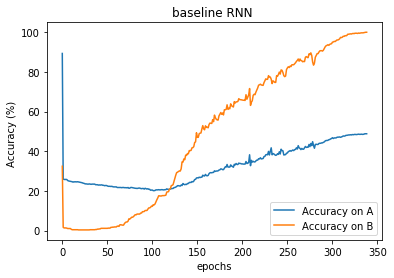

In [106]:
epoch=[i for i in range(len(Number_of_corrects_A))]
plt.plot(epoch,Number_of_corrects_A,epoch,Number_of_corrects_B)
plt.title("baseline RNN ")
plt.legend(['Accuracy on A','Accuracy on B'])
plt.xlabel("epochs")
plt.ylabel("Accuracy (%) ")
plt.show()

https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

#  Simulation 3: catastrophic forgetting is overcome with pseudopatterns



## parameters and model

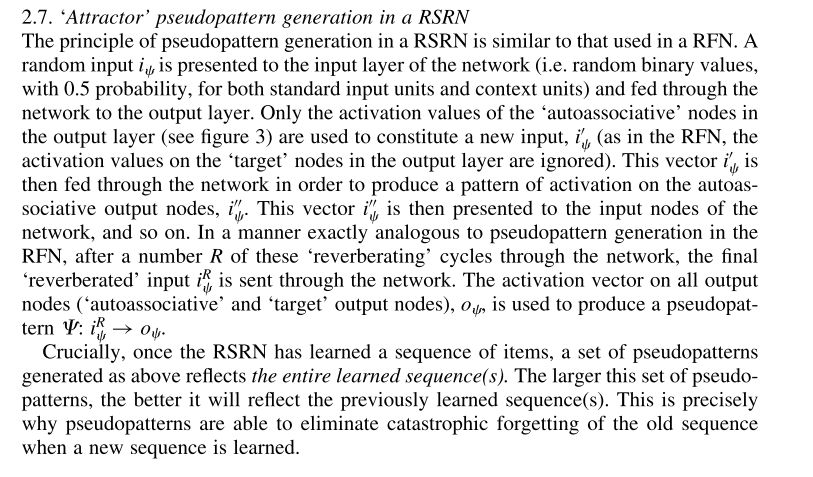

In [142]:
RNN_type="rnn"
N_Reverberated=5
Number_pseudopatterns_netLearn_to_netStorage=10**4
Number_pseudopatterns_netStorage_to_netLearn=10

input_dim = 100    # input dimension
autoassociative_dim=input_dim
hidden_dim = 50  # hidden layer dimension
layer_dim = 1     # number of hidden RNN layers
output_dim = input_dim+autoassociative_dim   # output dimension

batch_size = 1
seq_len=11
 
A=torch.randint(2,(batch_size,seq_len,input_dim)).float() #generate rnadom binary vector of length 100 
A[:,5,:]=A[:,8,:]
B=torch.randint(2,(batch_size,seq_len,input_dim)).float()
B[:,1,:]=B[:,5,:]

NET_1 = RNNModel(input_dim, hidden_dim, layer_dim, output_dim,RNN_type="rnn") # learning 
NET_2 = RNNModel(input_dim, hidden_dim, layer_dim, output_dim,RNN_type="rnn") # storage


In [143]:
def reverbating(inputs,model,RNN_type,seq_len):
    with torch.no_grad():
        hidden=model.init_hidden(inputs,rng=True)
        c=model.init_hidden(inputs,rng=True)

        size_inputs=inputs[:,0,:].size()
        input_rnn=inputs[:,0,:].view(size_inputs[0],1,size_inputs[1])

        for t in range(seq_len):
            if model.RNN_type=="lstm":
                outputs,hidden,c = model(input_rnn,h=hidden,c=c)
            else:
                outputs,hidden,_ = model(input_rnn,h=hidden) 
            
            out=outputs.detach()
            input_rnn=torch.sigmoid(out.view(size_inputs[0],1,size_inputs[1]))
    return input_rnn

In [144]:
# model_generate pseudopatterns while model_train is train with them
def train_with_pseudopatterns(model_generate,model_train,Number_pseudopatterns=10**4):
    pseudo_pattern=torch.randint(2,(Number_pseudopatterns,1,input_dim)).float()
    


In [145]:
pseudo_pattern=torch.randint(2,(Number_pseudopatterns,1,input_dim)).float()
pseudo_pattern.size()

torch.Size([10000, 1, 100])

In [147]:
hidden=NET_1.init_hidden(pseudo_pattern,True)
c=NET_1.init_hidden(pseudo_pattern,True)
outputs,hidden,_=NET_1(pseudo_pattern,h=hidden,c=c)

In [148]:
torch.zeros(1, pseudo_pattern.size(0), 50).size()

torch.Size([1, 10000, 50])

In [301]:
RNN_type="rnn"
criterion = nn.BCEWithLogitsLoss(reduction='sum')# Sigmoid layer and the BCELoss
optimizer = optim.Adam(NET_1.parameters(), lr=0.01) #lstm gru=0.1 rnn=0.01

inputs=A[:,:-1,:] #remove A(10) 
labels=A[:,1:,:]#remove A(0) 
#print(inputs.size(),A.size(),labels.size()) #(torch.Size([1, 10, 100]), torch.Size([1, 11, 100]), torch.Size([1, 10, 100]))
for i in range(500):
    optimizer.zero_grad()
    if NET_1.RNN_type=="lstm":
        outputs = NET_1(inputs,h=NET_1.init_hidden(inputs),c=NET_1.init_hidden(inputs))
    else:
        outputs = NET_1(inputs,h=NET_1.init_hidden(inputs)) 
    loss=criterion(outputs,labels.view(-1, output_dim))
    loss.backward()
    optimizer.step()
    accuracy,corrects=get_accuracy(torch.sigmoid(outputs), labels, batch_size=1,treshold=0.1)
    print('Iteration: {}  Loss: {:.3f}  Accuracy: {:.1f} % Correct: {:.1f} / {} '.format(i, loss.item(), accuracy,corrects,output_dim*batch_size*(seq_len-1)))
    if corrects==output_dim*batch_size*(seq_len-1): 
        print("A fully learn with",i,"epochs")
        break
print("WARNING A is not0 fully learn with",i,"epochs")

Iteration: 0  Loss: 701.802  Accuracy: 0.0 % Correct: 0.0 / 1000 
Iteration: 1  Loss: 671.133  Accuracy: 0.0 % Correct: 0.0 / 1000 
Iteration: 2  Loss: 640.188  Accuracy: 0.0 % Correct: 0.0 / 1000 
Iteration: 3  Loss: 600.540  Accuracy: 0.0 % Correct: 0.0 / 1000 
Iteration: 4  Loss: 558.145  Accuracy: 0.4 % Correct: 4.0 / 1000 
Iteration: 5  Loss: 511.436  Accuracy: 2.7 % Correct: 27.0 / 1000 
Iteration: 6  Loss: 460.664  Accuracy: 6.6 % Correct: 66.0 / 1000 
Iteration: 7  Loss: 407.122  Accuracy: 12.5 % Correct: 125.0 / 1000 
Iteration: 8  Loss: 351.873  Accuracy: 24.2 % Correct: 242.0 / 1000 
Iteration: 9  Loss: 296.347  Accuracy: 36.4 % Correct: 364.0 / 1000 
Iteration: 10  Loss: 243.779  Accuracy: 49.6 % Correct: 496.0 / 1000 
Iteration: 11  Loss: 194.080  Accuracy: 61.0 % Correct: 610.0 / 1000 
Iteration: 12  Loss: 150.682  Accuracy: 69.7 % Correct: 697.0 / 1000 
Iteration: 13  Loss: 114.170  Accuracy: 77.3 % Correct: 773.0 / 1000 
Iteration: 14  Loss: 83.245  Accuracy: 83.7 % Cor

# draft

learn a

In [ ]:
RNN_type="rnn"
model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim,RNN_type)

criterion = nn.BCEWithLogitsLoss(reduction='sum')# Sigmoid layer and the BCELoss
optimizer = optim.Adam(model.parameters(), lr=0.01) #lstm gru=0.1 rnn=0.01

inputs=A[:,:-1,:] #remove A(10) 
labels=A[:,1:,:]#remove A(0) 
#print(inputs.size(),A.size(),labels.size()) #(torch.Size([1, 10, 100]), torch.Size([1, 11, 100]), torch.Size([1, 10, 100]))
for i in range(500):
    optimizer.zero_grad()
    if model.RNN_type=="lstm":
        outputs,_,_ = model(inputs,h=model.init_hidden(inputs),c=model.init_hidden(inputs))
    else:
        outputs,_,_ = model(inputs,h=model.init_hidden(inputs)) 
    loss=criterion(outputs,labels.view(-1, output_dim))
    loss.backward()
    optimizer.step()
    accuracy,corrects=get_accuracy(torch.sigmoid(outputs), labels, batch_size=1,treshold=0.1)
    print('Iteration: {}  Loss: {:.3f}  Accuracy: {:.1f} % Correct: {:.1f} / {} '.format(i, loss.item(), accuracy,corrects,output_dim*batch_size*(seq_len-1)))
    if corrects==output_dim*batch_size*(seq_len-1): 
        print("A fully learn with",i,"epochs")
        break
print("WARNING A is not0 fully learn with",i,"epochs")

learn b

In [ ]:
inputs=B[:,:-1,:] #remove A(10) 
labels=B[:,1:,:]#remove A(0) 
#print(inputs.size(),A.size(),labels.size()) #(torch.Size([1, 10, 100]), torch.Size([1, 11, 100]), torch.Size([1, 10, 100]))
Number_of_corrects_A=[]
Number_of_corrects_B=[]
loss_B,accuracy_B,corrects_B=N_correct_liste(model,B)
Number_of_corrects_B.append(accuracy_B)


loss_A,accuracy_A,corrects_A=N_correct_liste(model,A)
Number_of_corrects_A.append(accuracy_A)

model.train()
for i in range(500):

    optimizer.zero_grad()
    outputs = model(inputs,h=model.init_hidden(inputs),c=model.init_hidden(inputs)) 
    outputs.size()
    loss=criterion(outputs,labels.view(-1, output_dim))
    loss.backward()
    optimizer.step()
    accuracy,corrects=get_accuracy(torch.sigmoid(outputs), labels, batch_size=1,treshold=0.1)
    print('Iteration: {}  Loss: {:.3f}  Accuracy: {:.1f} % Correct: {:.1f} / {} '.format(i, loss.item(), accuracy,corrects,output_dim*batch_size*(seq_len-1)))
    Number_of_corrects_A.append(N_correct_liste(model,A)[1])
    Number_of_corrects_B.append(N_correct_liste(model,B)[1])
    if corrects==output_dim*batch_size*(seq_len-1): 
        break
print("B fully learn with",i,"epochs")